<a href="https://colab.research.google.com/github/Nicordaro/Homework2-Caltech101/blob/master/Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
#!pip3 install 'torch==1.4.0'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import random
import torch
import copy

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
import torchvision.models as models

from sklearn import model_selection
import matplotlib
import numpy 
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm
import time


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

modelchosen = 'pretrained'
#modelchosen = 'not_trained'
#modelchosen = 'resnet'
#modelchosen = 'vgg'

#use true or false to chose between augmentation of the dataset or not
augment = True


NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
#BATCH_SIZE = 512     # the batch size, learning rate should change by the same factor to have comparable results

#LR = 1e-3
#LR = .1
LR = .01         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20
#STEP_SIZE = 30       # How many epochs before decreasing learning rate (if using a step-down policy)
#GAMMA = 0.1
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10



**Define Data Preprocessing**

In [4]:


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])


if augment:
  TL_train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                           
                                      transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),

                                      transforms.CenterCrop(224),  # Image net standards
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
  ])
  print('Data augmentation: Used')
else:
  TL_train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Image net standards
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
  ])
  print('Data augmentation: Not used')
#validation doesn't use augmentation
TL_eval_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])



Data augmentation: Used


**TL True/False Dataset Prepare**

In [5]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/Nicordaro/Homework2-Caltech101
  !mv 'Homework2-Caltech101' 'Caltech101'

start_time = time.time()

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

if modelchosen != 'not_trained':
  # Prepare Pytorch train/test Datasets
  train_dataset_or = Caltech(DATA_DIR, split='train',  transform=TL_train_transform)
  test_dataset = Caltech(DATA_DIR, split='test', transform=TL_eval_transform)
else:
  # Prepare Pytorch train/test Datasets
  train_dataset_or = Caltech(DATA_DIR, split='train',  transform=train_transform)
  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

indexes = train_dataset_or.train_idx

#shuffle indexes
numpy.random.shuffle(indexes)


half = int(len(indexes)/2)

train_indexes = indexes[:half] # split the indices for your train split
val_indexes = indexes[half:] # split the indices for your val split

train_dataset = Subset(train_dataset_or, train_indexes)
val_dataset = Subset(train_dataset_or, val_indexes)

test_dataset = Subset(test_dataset, test_dataset.test_idx)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9301 (delta 0), reused 0 (delta 0), pack-reused 9298
Receiving objects: 100% (9301/9301), 129.50 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (9150/9150), done.
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [7]:
# Loading AlexNet model
if modelchosen == 'pretrained':
  net = models.alexnet(pretrained=True)
elif modelchosen == 'resnet':
  net = models.resnet18(pretrained=True)
elif modelchosen == 'vgg':
  net = models.vgg16(pretrained=True)
else:
  net = models.alexnet()

best_model = net
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
if modelchosen != 'resnet':
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
else:
  net.fc = nn.Linear(512,NUM_CLASSES)

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

##Decide which layers you want to freeze and which you want to optimize
optimize = 'default' #optimize everything
#optimize = 'fully' #optimize fully and freeze convolutional
#optimize = 'convolutional' #optimize convolutional and freeze fully

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) ( net.features.parameters() )
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

if optimize == 'default':
  parameters_to_optimize = net.parameters()
elif optimize == 'fully':
  parameters_to_optimize = net.classifier.parameters()
elif optimize == 'convolutional':
  parameters_to_optimize = net.features.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##LET'S TRY OTHERS
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adadelta(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**2- Training**

In [9]:

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

losses = []
accuracies = []

current_step = 0
best_acc = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
      losses.append(loss.item())

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  #find the best model each step

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

      # Forward Pass
    outputs = net(images)

      # Get predictions
    _, preds = torch.max(outputs.data, 1)

      # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  print('\nValidation Accuracy: {}'.format(accuracy))
  accuracies.append(accuracy)
  if accuracy > best_acc:
    best_acc = accuracy
    best_model = copy.deepcopy(net)
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.874167442321777
Step 10, Loss 2.397724151611328

Validation Accuracy: 0.5567081604426003
Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.8193413615226746

Validation Accuracy: 0.7244121715076072
Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.5404248237609863

Validation Accuracy: 0.7655601659751037
Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.346993088722229

Validation Accuracy: 0.7863070539419087
Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.22756123542785645

Validation Accuracy: 0.7759336099585062
Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.13874179124832153

Validation Accuracy: 0.7935684647302904
Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.13366340100765228

Validation Accuracy: 0.7925311203319502
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.09768888354301453

Validation Accuracy: 0.7859612724757953
Starting epoch 9/30, LR = [0.01]
Step 90, Loss 0.06430888175964355

Validation Accuracy: 0.7956431535269709
Sta

**Validation**

In [10]:
net = best_model
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:16<00:00,  1.37s/it]

Validation Accuracy: 0.8170816044260027


**Test**

In [11]:
net = best_model
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
tot_time = (time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 12/12 [00:13<00:00,  1.15s/it]

Test Accuracy: 0.8081576218458347
--- 1042.3077039718628 seconds ---


**Visual representation of Accuracy and Loss**

1042.3076665401459


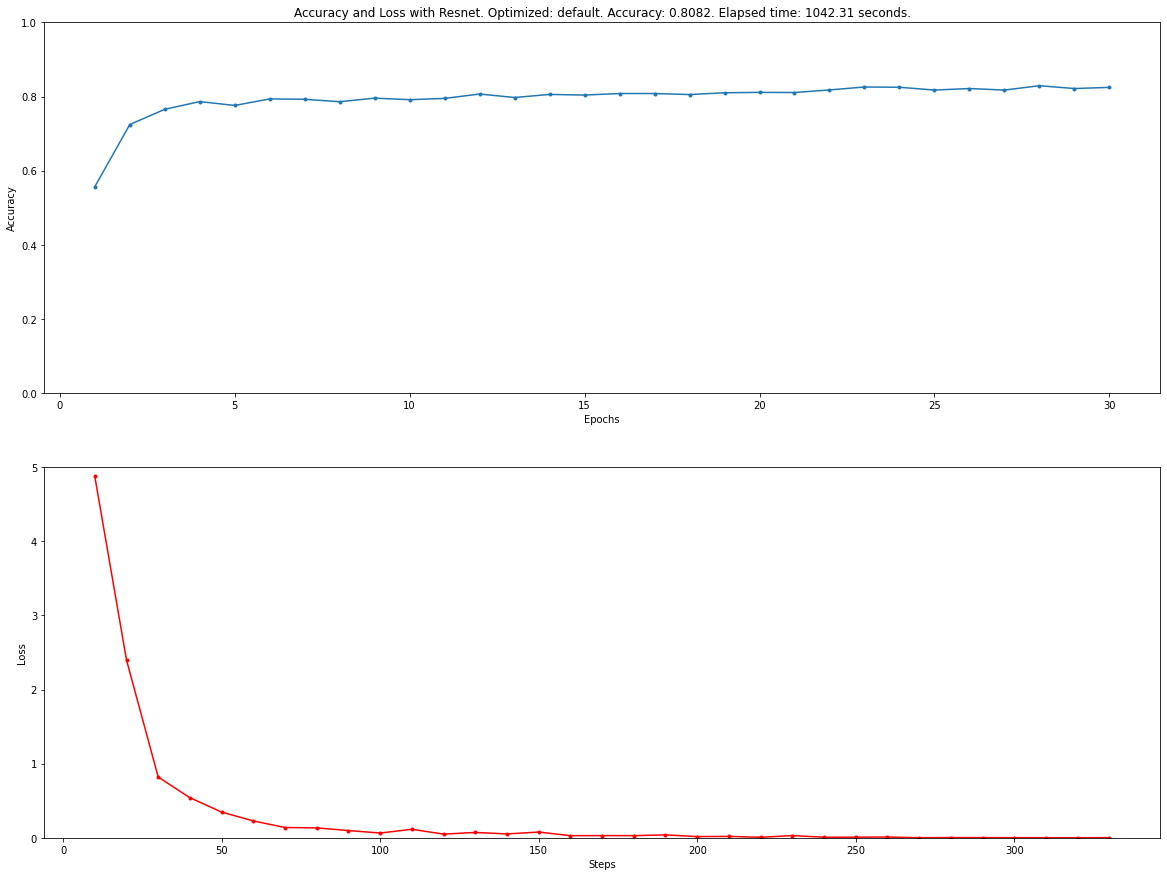

In [12]:
x1 = numpy.arange(1, 31)
x2 = numpy.arange(1, len(losses)+1)
x2 = x2*10
y1 = accuracies
y2 = losses
print(tot_time)
plt.figure(figsize=(20,15), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(x1, y1, '.-')
title = 'Accuracy and Loss with Resnet. Optimized: '+optimize+'. Accuracy: %.4f. Elapsed time: %.2f seconds.' % (accuracy, tot_time)
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)


plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-', color ='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim(0, 5)

plt.show()